# Viscoelastic wave propagator with Maxwell formulation

This tutorial was prepared by Paula Neves de Araujo (paulan@ime.usp.br).

This tutorial is an introduction to the isotropic viscoelastic wave propagator of Spyro using the Maxwell formulation. The tutorial is an adaptation of the elastic forward notebook.

First, the notebook environment is configured and the required modules are imported. If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:

```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [2]:
%matplotlib inline
import spyro
import numpy as np

from firedrake import *

In [86]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": True,
        "visco_type": 'maxwell',
        "tau_sigma": 1.0,
        "tau_epsilon": 5.0,
        "lmbda_s": [0.1],
        "mu_s": [0.05],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])


Note that "viscoelastic" is set to **True**. If this parameter is set to **False**, the elastic wave propagation is performed. We also have the "visco_type" parameter which is used to define the model to be adopted. Three options are implemented for now: 'kelvin-voigt', 'zener' and 'gsls'. In this notebook, we address the **Maxwell model**, which describes the viscoelastic behavior of materials by combining a purely elastic spring and a purely viscous dashpot in **series**.

In this configuration, the **total strain** is the sum of the elastic and viscous strains, while the **stress** is the same in both elements:

$$
\varepsilon = \varepsilon_e + \varepsilon_v, 
\qquad 
\sigma = \sigma_e = \sigma_v
$$

The constitutive equation can be expressed as:

$$
\dot{\sigma} + \frac{\sigma}{\tau} = \lambda \, \text{tr}(\dot{\varepsilon}) \, I + 2\mu \, \dot{\varepsilon}
$$

where:

- $\sigma$ is the stress tensor  
- $\varepsilon$ is the strain tensor  
- $\dot{\varepsilon}$ is the strain rate  
- $\lambda$ and $\mu$ are the Lamé parameters (elastic moduli)  
- $\tau = \eta / \mu$ is the **relaxation time**, relating viscosity $\eta$ and the shear modulus $\mu$  
- $I$ is the identity tensor  
- $\text{tr}(\dot{\varepsilon})$ is the trace of the strain-rate tensor  

This model describes materials that **relax stress over time** when held at constant strain — a key feature of viscoelastic relaxation.  
In seismic modeling, the Maxwell model serves as a building block for more general formulations, such as the **Generalized Maxwell (GSLS)** or **Zener** models, which extend this behavior to multiple relaxation mechanisms and enable realistic simulation of **wave attenuation and dispersion**.


In the following, we build the "wave" object, which is an instance of "wave" type, and also stablish a periodic mesh for the example:

In [87]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Finally, the wave propagation can be performed:

In [88]:
wave.forward_solve()

Viscoelastic Maxwell
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


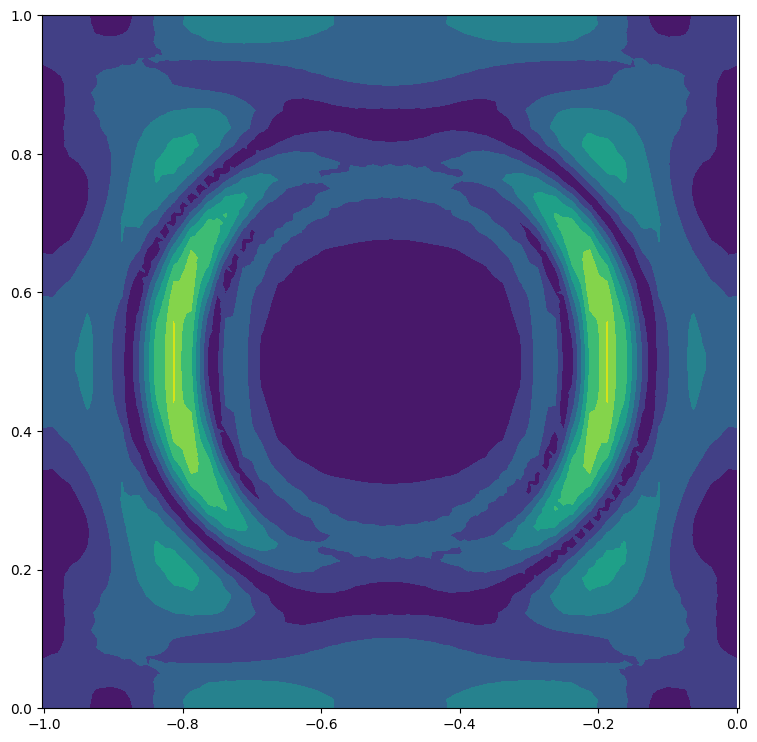

In [89]:
spyro.plots.plot_function(wave.u_n)

In the following, we show that, for $\eta$ sufficiently big, the results converge to the elastic case. We redefine the parameters dictionary and set "viscoelastic" as **False**:

In [90]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": False,
        "visco_type": 'maxwell',
        "tau_sigma": 1.0,
        "tau_epsilon": 5.0,
        "lmbda_s": [0.1],
        "mu_s": [0.05],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])


Then we run the commands for the wave construction and propagation:

In [91]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Isotropic elastic
Saving Displacement in: results/forward_outputsn0.pvd
Simulation time is:        0.0 seconds


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


We obtain the following result:

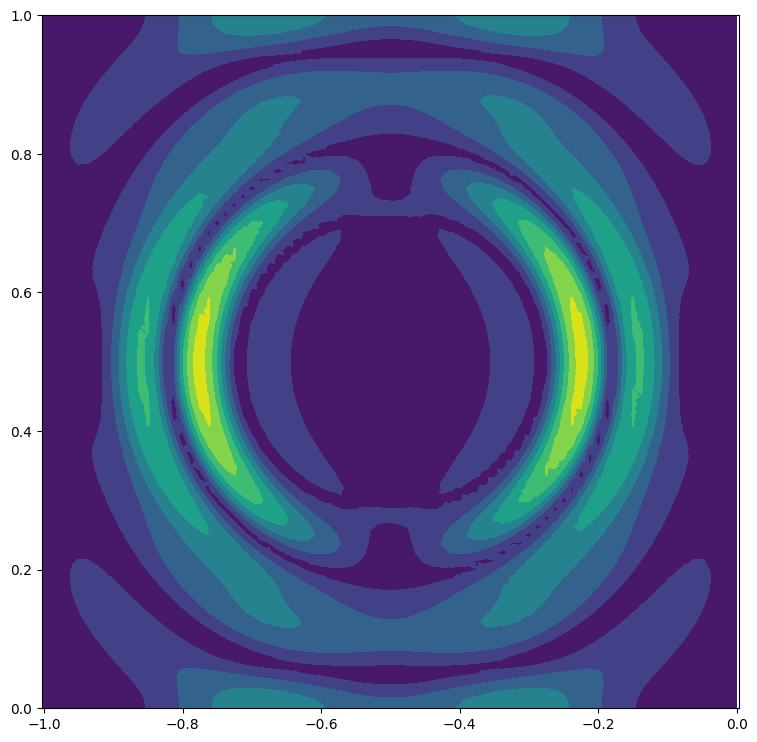

In [92]:
spyro.plots.plot_function(wave.u_n)

Finally, we run the same code for the viscoelastic Maxwell model with different sets of parameters:

In [93]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": True,
        "visco_type": 'maxwell',
        "tau_sigma": 7.0,
        "tau_epsilon": 10.0,
        "lmbda_s": [0.1],
        "mu_s": [0.05],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])


In [94]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic Maxwell
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


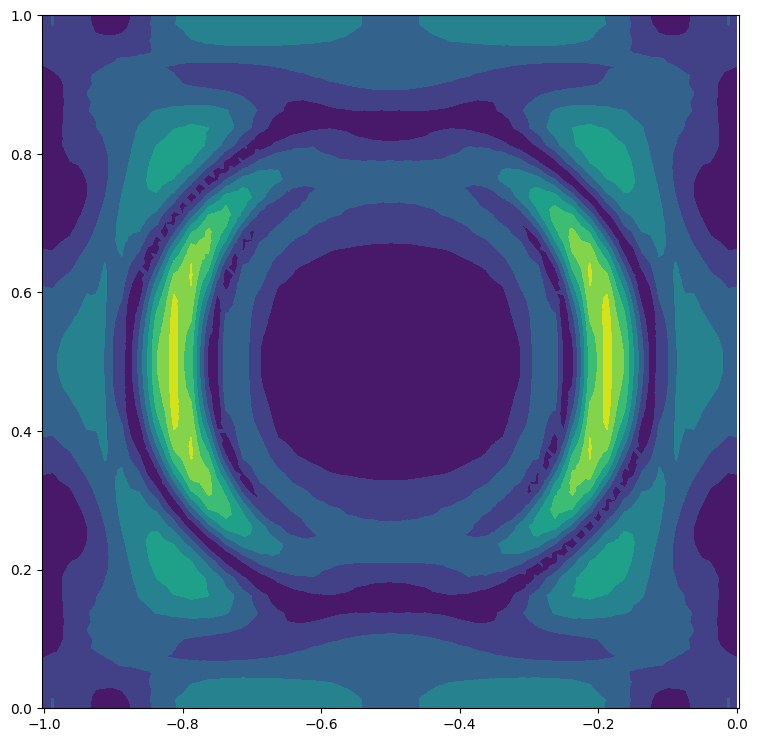

In [95]:
spyro.plots.plot_function(wave.u_n)

We can also compare the results obtained for different values of $\eta.$ Let us redefine $\eta=10^{-8}:$

In [118]:
dictionary["viscoelasticity"] = {
        "viscoelastic": True,
        "visco_type": 'maxwell',
        "tau_sigma": 700.0,
        "tau_epsilon": 1000.0,
        "lmbda_s": [0.1],
        "mu_s": [0.05],
    }

Then we run the results for the new dictionary:

In [ ]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic Maxwell
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds


In [ ]:
spyro.plots.plot_function(wave.u_n)